In [1]:
import sys
import os

this_path = os.getcwd()
path = '\\'.join(this_path.split('\\')[:-1])+'\\'
if path not in sys.path:
    sys.path.insert(0, path)
    print(path+" added to python path")
else:
    print(path+" already in python path")

C:\Users\mgutierrez\root\Projects\SDC\py\kaissandra\ added to python path


In [2]:
def init_ema_variations(data, SymbolVar, nExS, mW):
    """ Init EMA vector for variation-based features.
    Args:
        - data (Data object): data info.
    Return:
        - em (np array): initialized EMA vector. """
    # init exponetial means
    em = np.zeros((data.lbd.shape))+SymbolVar[0]
    for i in range(nExS-mW):
        em = data.lbd*em+(1-data.lbd)*SymbolVar[i]
        
    return em

def init_parsar(data, firstSymbol):
    """ Init ParSar object.
    Args:
        - data (Data object): data-related parameters.
        - firstSymbol (float): first symbol value (bid, variation, ...).
    Return:
        - ParSar (ParSar object): initialized ParSar structure. """
    class ParSar:
        oldSARh = firstSymbol+np.zeros((len(data.parsars)))
        oldSARl = firstSymbol+np.zeros((len(data.parsars)))
        HP = np.zeros((len(data.parsars)))
        LP = 100000+np.zeros((len(data.parsars)))
        stepAF = 0.02
        AFH = stepAF+np.zeros((len(data.parsars)))
        AFL = stepAF+np.zeros((len(data.parsars)))
        maxAF = np.array(data.parsars)*stepAF
    
    return ParSar

def update_parsar(data, parsar, min_value, max_value, thisPeriodVariations):
    """ Update ParSar values and structure.
    Args:
        - parsar (ParSar object): structure with current values of Par Sar.
        - min_value (int): min value of current window.
        - max_value (int): max value of current window
        - thisPeriodVariations (np array): variation values of current period.
    Return:
        - parsar (ParSar object): updated structure with current values of Par Sar.
        - parSARhigh (np vector): current high par sar values.
        - parSARlow (np vector): current low par sar values."""
    thisParSARhigh = np.zeros((len(data.parsars)))
    thisParSARlow = np.zeros((len(data.parsars)))
    for ps in range(len(data.parsars)):
        parsar.HP[ps] = np.max([max_value,parsar.HP[ps]])
        parsar.LP[ps] = np.min([min_value,parsar.LP[ps]])
        thisParSARhigh[ps] = parsar.oldSARh[ps]+parsar.AFH[ps]*(parsar.HP[ps]-parsar.oldSARh[ps])
        thisParSARlow[ps] = parsar.oldSARl[ps]-parsar.AFL[ps]*(parsar.oldSARl[ps]-parsar.LP[ps])
        if thisParSARhigh[ps]<parsar.HP[ps]:
            parsar.AFH[ps] = np.min([parsar.AFH[ps]+parsar.stepAF,parsar.maxAF[ps]])
            parsar.LP[ps] = np.min(thisPeriodVariations)
        if thisParSARlow[ps]>parsar.LP[ps]:
            parsar.AFL[ps] = np.min([parsar.AFH[ps]+parsar.stepAF,parsar.maxAF[ps]])
            parsar.HP[ps] = np.max(thisPeriodVariations)
        parsar.oldSARh[ps] = thisParSARhigh[ps]
        parsar.oldSARl[ps] = thisParSARlow[ps]
            
    return parsar, thisParSARhigh, thisParSARlow

def get_features_from_var_raw(data, features_manual, features_tsf, DateTime, SymbolVar, nExS, mW, nE, m):
    """
    Function that calculates features from raw data in per batches
    Args:
        - data
        - features
        - DateTime
        - SymbolBid
    Returns:
        - features
    """    
    tic = time.time()
    # init scalars
    
    secsInDay = 86400.0
    var_feat_keys_manual = data.var_feat_keys
    em = init_ema_variations(data, SymbolVar, nExS, mW)
    n_feats_tsfresh = data.n_feats_tsfresh
    feature_keys_tsfresh = data.feature_keys_tsfresh
    
    parSar = init_parsar(data, SymbolVar[0])
    
    batch_size = 10000000
    par_batches = int(np.ceil(m/batch_size))
    l_index = 0
    # loop over batched
    for b in range(par_batches):
        # get m
        m_i = np.min([batch_size, m-b*batch_size])
        
        # init structures
        tsf = np.zeros((m_i, n_feats_tsfresh))
        EMA = np.zeros((m_i, em.shape[0]))
        variations = np.zeros((m_i))
        variance = np.zeros((m_i))
        maxValue = np.zeros((m_i))
        minValue = np.zeros((m_i))
        timeInterval = np.zeros((m_i))
        timeSecs = np.zeros((m_i))
        parSARhigh = np.zeros((m_i, len(data.parsars)))
        parSARlow = np.zeros((m_i, len(data.parsars)))
 
        for mm in range(m_i):
            
            startIndex = l_index+mm*mW
            endIndex = startIndex+nExS
            thisPeriod = range(startIndex,endIndex)
            thisPeriodVariations = SymbolVar[thisPeriod]
            newBidsIndex = range(endIndex-mW,endIndex)
            
            # tsfresh features
            c = 0
            for f in feature_keys_tsfresh:
                params = data.AllFeatures[str(f)]
                n_new_feats = params[-1]
                params = data.AllFeatures[str(f)]
                feats = feval(params[0],thisPeriodVariations,params[1:])
                n_new_feats = params[-1]
                tsf[mm,c:c+n_new_feats] = feats
                c += n_new_feats
                    
            
            condition_ema = 69 in var_feat_keys_manual or 70 in var_feat_keys_manual or 71 in var_feat_keys_manual\
                or 72 in var_feat_keys_manual or 73 in var_feat_keys_manual or 74 in var_feat_keys_manual\
                or 75 in var_feat_keys_manual
            if condition_ema:
                for i in newBidsIndex:
                    em = data.lbd*em+(1-data.lbd)*SymbolVar[i]
            if 77 in var_feat_keys_manual:
                t0 = dt.datetime.strptime(DateTime[thisPeriod[0]].decode("utf-8"),'%Y.%m.%d %H:%M:%S')
                te = dt.datetime.strptime(DateTime[thisPeriod[-1]].decode("utf-8"),'%Y.%m.%d %H:%M:%S')
                timeInterval[mm] = (te-t0).seconds/nExS
            if 68 in var_feat_keys_manual:
                variations[mm] = SymbolVar[thisPeriod[-1]]
            if condition_ema:
                EMA[mm,:] = em
            if 76 in var_feat_keys_manual:
                variance[mm] = np.var(thisPeriodVariations)
            if 83 in var_feat_keys_manual:
                maxValue[mm] = np.max(thisPeriodVariations)
            if 84 in var_feat_keys_manual:
                minValue[mm] = np.min(thisPeriodVariations)
            if 82 in var_feat_keys_manual:
                timeSecs[mm] = (te.hour*60*60+te.minute*60+te.second)/secsInDay
            condition_parsar = 78 in var_feat_keys_manual or 79 in var_feat_keys_manual \
                or 80 in var_feat_keys_manual or 81 in var_feat_keys_manual
            if condition_parsar:
                parSar, parSARhigh[mm,:], parSARlow[mm,:] = update_parsar\
                    (data, parSar, minValue[mm], maxValue[mm], thisPeriodVariations)
            
        # end of for mm in range(m_i):
        l_index = startIndex+mW
        #print(l_index)
        toc = time.time()
        print("\t\tmm="+str(b*batch_size+mm+1)+" of "+str(m)+". Total time: "+str(np.floor(toc-tic))+"s")
        # update features vector
        init_idx = b*batch_size
        end_idx = b*batch_size+m_i
        
        epsilon = 1e-10
        if n_feats_tsfresh>0:
            features_tsf[init_idx:end_idx,:] = tsf
        nF = 0
        #nF += n_feats_tsfresh
        if 68 in var_feat_keys_manual:
            features_manual[init_idx:end_idx,nF] = variations
            nF += 1
        if condition_ema:
            features_manual[init_idx:end_idx,nF:nF+data.lbd.shape[0]] = EMA
            nF += data.lbd.shape[0]
        if 76 in var_feat_keys_manual:
            logVar = 10*np.log10(variance/data.std_var+1e-10)
            features_manual[init_idx:end_idx,nF] = logVar
            nF += 1
        if 77 in var_feat_keys_manual:
            logInt = 10*np.log10(timeInterval/data.std_time+0.01)
            features_manual[init_idx:end_idx,nF] = logInt
            nF += 1
        if condition_parsar:
            for ps in range(len(data.parsars)):
                features_manual[init_idx:end_idx,nF] = parSARhigh[:,ps]
                nF += 1
                features_manual[init_idx:end_idx,nF] = parSARlow[:,ps]
                nF += 1
        if 82 in var_feat_keys_manual:
            features_manual[init_idx:end_idx,nF] = timeSecs
            nF += 1
        if 83 in var_feat_keys_manual:
            features_manual[init_idx:end_idx,nF] = maxValue
            nF += 1
        if 84 in var_feat_keys_manual:
            features_manual[init_idx:end_idx,nF] = minValue
            nF += 1
        if 85 in var_feat_keys_manual:
            features_manual[init_idx:end_idx,nF] = np.sign(minValue)*np.log(np.abs(minValue)+epsilon)-\
                    np.sign(maxValue)*np.log(np.abs(maxValue)+epsilon)
            nF += 1
        condition_varOema = 86 in var_feat_keys_manual or 87 in var_feat_keys_manual\
            or 88 in var_feat_keys_manual or 89 in var_feat_keys_manual or 90 in var_feat_keys_manual\
            or 91 in var_feat_keys_manual or 92 in var_feat_keys_manual
        if condition_varOema:
            for i in range(data.lbd.shape[0]):          
                features_manual[init_idx:end_idx,nF] = np.sign(variations)*np.log(np.abs(variations)+epsilon)-\
                    np.sign(EMA[:,i])*np.log(np.abs(EMA[:,i])+epsilon)
                nF += 1
            
    return features_manual, features_tsf

def calculate_stats_from_var_feats(features):
    """  """
    nF = features.shape[1]
    stats = {}
    stats["means"] = np.zeros((1,nF))
    stats["stds"] = np.zeros((1,nF))
    stats["m"] = features.shape[0]
    
    #print("\t getting means and stds from features")
    # loop over channels
    stats["means"][0,:] = np.mean(features,axis=0,keepdims=1)
    stats["stds"][0,:] = np.std(features,axis=0,keepdims=1)
    
    return stats

def get_returns(data, returns, symbols, nE, nExS, mW, m_in):
    """
    Function that obtains the outputs from raw data.
    Args:
        - data:
        - DateTime:
        - SymbolBid:
        - SymbolAsk:
    Returns:
        - outputs:
        - ret_idx:
    """
    initRange = int(nExS/mW)
    
    np_00 = initRange*data.movingWindow-1
    np_e0 = m_in*data.movingWindow-1
    
    indexOrigins = [i for i in range(np_00,np_e0,data.movingWindow)]

    for nr in range(len(data.lookAheadVector)):
        unp_0e = int(initRange*data.movingWindow+np.floor(data.nEventsPerStat*data.lookAheadVector[nr])-2)
        unp_ee = int(np.min([m_in*data.movingWindow+np.floor(
                data.nEventsPerStat*data.lookAheadVector[nr])-2,nE]))
        indexEnds = [i for i in range(unp_0e,unp_ee,data.movingWindow)]
        #fill ends wth last value
        for i in range(len(indexEnds),len(indexOrigins)):
            indexEnds.append(nE-1)
        returns[:,nr] = symbols[indexEnds]-symbols[indexOrigins]
    
    return returns

def get_symbols(data, DT, B, A, DateTime, SymbolBid, SymbolAsk, nE, nExS, mW, m_in):
    """  """
    initRange = int(nExS/mW)
    
    np_00 = initRange*data.movingWindow-1
    np_e0 = m_in*data.movingWindow-1
    
    indexOrigins = [i for i in range(np_00,np_e0,data.movingWindow)]
    DT[:,0] = DateTime[indexOrigins]
    B[:,0] = SymbolBid[indexOrigins]
    A[:,0] = SymbolAsk[indexOrigins]
    for nr in range(len(data.lookAheadVector)):
        unp_0e = int(initRange*data.movingWindow+np.floor(data.nEventsPerStat*data.lookAheadVector[nr])-2)
        unp_ee = int(np.min([m_in*data.movingWindow+np.floor(
                data.nEventsPerStat*data.lookAheadVector[nr])-2,nE]))
        indexEnds = [i for i in range(unp_0e,unp_ee,data.movingWindow)]
        #fill ends wth last value
        for i in range(len(indexEnds),len(indexOrigins)):
            indexEnds.append(nE-1)
        DT[:,nr+1] = DateTime[indexEnds]
        B[:,nr+1] = SymbolBid[indexEnds]
        A[:,nr+1] = SymbolAsk[indexEnds]
        
    return DT, B, A
def calculate_stats_from_returns(returns):
    """  """
    nR = returns.shape[1]
    stats = {}
    stats["means"] = np.zeros((1,nR))
    stats["stds"] = np.zeros((1,nR))
    stats["m"] = returns.shape[0]
    
    print("\t getting means and stds from returns")
    # get output stats
    stats["stds"] = np.std(returns,axis=0)
    stats["means"] = np.mean(returns,axis=0)
    
    return stats

def retrieve_manual_features_structure(file_features, group_name, m_in, nF):
    """ Retrieve features structure """
    
    if group_name not in file_features:
        group = file_features.create_group(group_name)
        features = group.create_dataset("features", (m_in,nF),dtype=float)
        exist = False
    else:
        features = file_features[group_name]["features"]
        exist = True
    
    return features, exist

def retrieve_tsf_features_structure(file_features, group_name, m_in, nF):
    """ Retrieve features structure """
    
    if group_name not in file_features:
        group = file_features.create_group(group_name)
        features = group.create_dataset("features", (m_in,nF),dtype=float)
        exist = False
    else:
        features = file_features[group_name]["features"]
        exist = True
    
    return features, exist

def retrieve_returns_structure(file_returns, group_rets_name, m, nR):
    """  """
    if group_rets_name not in file_returns:
        group_rets = file_returns.create_group(group_rets_name)
        returns = group_rets.create_dataset("returns", (m,nR),dtype=float)
        exist = False
    else:
        returns = file_returns[group_rets_name]["returns"]
        exist = True
    
    return returns, exist
    
def retrieve_symbols_structure(file_symbs, group_symbs_name, m_out, nR):
    """  """
    if group_symbs_name not in file_symbs:
        group_symbs = file_symbs.create_group(group_symbs_name)
        DT = group_symbs.create_dataset("DT", (m_out,nR+1),dtype='S19')
        B = group_symbs.create_dataset("B", (m_out,nR+1),dtype=float)
        A = group_symbs.create_dataset("A", (m_out,nR+1),dtype=float)
        exist = False
    else:
        DT = file_symbs[group_symbs_name]["DT"]
        B = file_symbs[group_symbs_name]["B"]
        A = file_symbs[group_symbs_name]["A"]
        exist = True
    
    return DT, B, A, exist

def save_stats_fn(file, group_name, stats):
    """  """
    file[group_name].attrs.create("means", stats['means'], dtype=float)
    file[group_name].attrs.create("stds", stats['stds'], dtype=float)
    file[group_name].attrs.create("m", stats['m'], dtype=int)
    
def retrieve_stats(file, group_name):
    """  """
    stats = {}
    stats['means'] = file[group_name].attrs.get("means")
    stats['stds'] = file[group_name].attrs.get("stds")
    stats['m'] = file[group_name].attrs.get("m")
    return stats

# Helper functions
def get_init_end_dates(separators, s):
    """  """
    init_date = dt.datetime.strftime(dt.datetime.strptime(
                separators.DateTime.iloc[s],'%Y.%m.%d %H:%M:%S'),'%y%m%d%H%M%S')
    end_date = dt.datetime.strftime(dt.datetime.strptime(
               separators.DateTime.iloc[s+1],'%Y.%m.%d %H:%M:%S'),'%y%m%d%H%M%S')
    return init_date, end_date

def get_group_name(thisAsset, init_date, end_date):
    """ Geat group name in HDF5 file containing the features vector """
    return thisAsset+'/'+init_date+end_date+'/'

def get_io_number_samples(nE, nExS, mW):
    """  """
    # number of features and number of returns
    m_in = int(np.floor((nE/nExS-1)*nExS/mW)+1)
    m_out = int(m_in-nExS/mW)
    return m_in, m_out

In [3]:
# Wrapper over features extraction for one asset
def wrapper_notebook(var_feat_keys, feature_keys_tsfresh, filename_raw, feats_var_directory, 
                     separators_directory, ass, save_stats, save_stats_in_stats):
    """  """
    data = Data(var_feat_keys=var_feat_keys, feature_keys_tsfresh=feature_keys_tsfresh)
    f_raw = h5py.File(filename_raw,'r')
    thisAsset = data.AllAssets[str(ass)]
    print(thisAsset)
    nExS = data.nEventsPerStat
    mW = data.movingWindow
    nFman = len(data.var_feat_keys)
    nFtsf = data.n_feats_tsfresh
    
    group_raw = f_raw[thisAsset]
    
    filename_features_manual = (feats_var_directory+thisAsset+'_feats_var_mW'+str(data.movingWindow)+'_nE'+
                            str(data.nEventsPerStat)+'.hdf5')
    file_features_manual = h5py.File(filename_features_manual,'a')
    filename_features_tsf = (feats_var_directory+thisAsset+'_feats_tsf_mW'+str(data.movingWindow)+'_nE'+
                            str(data.nEventsPerStat)+'.hdf5')
    file_features_tsf = h5py.File(filename_features_tsf,'a')
    filename_returns = (feats_var_directory+thisAsset+'_rets_var_mW'+str(data.movingWindow)+'_nE'+
                            str(data.nEventsPerStat)+'.hdf5')
    file_returns = h5py.File(filename_returns,'a')
    filename_symbols = (feats_var_directory+thisAsset+'_symbols_mW'+str(data.movingWindow)+'_nE'+
                            str(data.nEventsPerStat)+'.hdf5')
    file_symbols = h5py.File(filename_symbols,'a')
    
    if save_stats:
        filename_stats = (feats_var_directory+thisAsset+'_stats_mW'+str(data.movingWindow)+'_nE'+
                                str(data.nEventsPerStat)+'.p')
        #file_stats = h5py.File(filename_stats,'a')
        stats = {"means_man_in":0.0,
                 "stds_man_in":0.0,
                 "means_tsf_in":0.0,
                 "stds_tsf_in":0.0,
                 "means_out":0.0,
                 "stds_out":0.0,
                 "m_in":0,
                 "m_out":0}

    # load separators
    separators = load_separators(data, thisAsset, separators_directory, from_txt=1)
    
    for s in range(4,5,2):#len(separators)-1
        
        nE = separators.index[s+1]-separators.index[s]+1
        # check if number of events is not enough to build two features and one return
        if nE-data.nEventsPerStat>=2*data.nEventsPerStat:
            print("\t"+" s {0:d} of {1:d}".format(int(s/2),int(len(separators)/2-1))+
                          ". From "+separators.DateTime.iloc[s]+" to "+separators.DateTime.iloc[s+1])
            
            DateTime = group_raw["DateTime"][separators.index[s]:separators.index[s+1]+1]
            SymbolBid = group_raw["SymbolBid"][separators.index[s]:separators.index[s+1]+1]
            SymbolAsk = group_raw["SymbolAsk"][separators.index[s]:separators.index[s+1]+1]
            
            SymbolVar = SymbolBid[nExS-1:]-SymbolBid[:-(nExS-1)]
            
            nE = SymbolVar.shape[0]
            
            init_date, end_date = get_init_end_dates(separators, s)
            
            group_name = get_group_name(thisAsset, init_date, end_date)
            
            m_in, m_out = get_io_number_samples(nE, nExS, mW)
            
            features_manual, exist_feats_manual = retrieve_manual_features_structure(file_features_manual, group_name, m_in, nFman)        

            features_tsf, exist_feats_tsf = retrieve_tsf_features_structure(file_features_tsf, group_name, m_in, nFtsf)

            if not exist_feats_manual or not exist_feats_tsf:
                print("Getting features")
                #features_manual, features_tsf = get_features_from_var_raw(data, features_manual, features_tsf, DateTime[nExS:], SymbolVar, nExS, mW, nE, m_in)
                
                if not exist_feats_manual:
                    stats_feats_manual = calculate_stats_from_var_feats(features_manual)

                    save_stats_fn(file_features_manual, group_name, stats_feats_manual)
                else:
                    print("\tManual features already exist")
                    stats_feats_manual = retrieve_stats(file_features_manual, group_name)
                    print(stats_feats_manual)
                    
                if not exist_feats_tsf:
                    stats_feats_tsf = calculate_stats_from_var_feats(features_tsf)

                    save_stats_fn(file_features_tsf, group_name, stats_feats_tsf)
                else:
                    print("\tTSF features already exist")
                    stats_feats_tsf = retrieve_stats(file_features_tsf, group_name)

            else:
                print("\tManual and TSF features already exist")
                
                stats_feats_manual = retrieve_stats(file_features_manual, group_name)
                print("stats_feats_manual")
                print(stats_feats_manual)
                
                stats_feats_tsf = retrieve_stats(file_features_tsf, group_name)
                print("stats_feats_tsf")
                print(stats_feats_tsf)
            
            returns, exist_rets = retrieve_returns_structure(file_returns, group_name, m_out, len(data.lookAheadVector))
    
            if not exist_rets:
                returns = get_returns(data, returns, SymbolBid, nE, nExS, mW, m_in)

                stats_rets = calculate_stats_from_returns(returns)

                save_stats_fn(file_returns, group_name, stats_rets)
            else:
                print("\tReturns already exist")
                stats_rets = retrieve_stats(file_returns, group_name)
                
            DT, B, A, exist_symbs = retrieve_symbols_structure(file_symbols, group_name, m_out, len(data.lookAheadVector))
    
            if not exist_symbs:
                DT, B, A = get_symbols(data, DT, B, A, DateTime, SymbolBid, SymbolAsk, nE, nExS, mW, m_in)

            else:
                print("\tSymbols already exist")
            
            if save_stats:
                stats["means_man_in"] += m_in*stats_feats_manual['means']
                stats["stds_man_in"] += m_in*stats_feats_manual['stds']
                stats["means_tsf_in"] += m_in*stats_feats_tsf['means']
                stats["stds_tsf_in"] += m_in*stats_feats_tsf['stds']
                stats["means_out"] += m_out*stats_rets['means']
                stats["stds_out"] += m_out*stats_rets['stds']
                stats["m_in"] += m_in
                stats["m_out"] += m_out

        else:
            print("\ts {0:d} of {1:d}. Not enough entries. Skipped.".format(int(s/2),int(len(separators)/2-1)))
    
    if save_stats:
        stats["means_man_in"] = stats["means_man_in"]/stats["m_in"]
        stats["stds_man_in"] = stats["stds_man_in"]/stats["m_in"]
        stats["means_tsf_in"] = stats["means_tsf_in"]/stats["m_in"]
        stats["stds_tsf_in"] = stats["stds_tsf_in"]/stats["m_in"]
        stats["means_out"] = stats["means_out"]/stats["m_out"]
        stats["stds_out"] = stats["stds_out"]/stats["m_out"]
        
        # group for stats in features file
        group_feats_man = file_features_manual[thisAsset]
        group_feats_man.attrs.create("means_in", stats["means_man_in"], dtype=float)
        group_feats_man.attrs.create("stds_in", stats["stds_man_in"], dtype=float)
        group_feats_man.attrs.create("m_in", stats["m_in"], dtype=int)
        
        # group for stats in features file
        group_feats_tsf = file_features_tsf[thisAsset]
        group_feats_tsf.attrs.create("means_in", stats["means_tsf_in"], dtype=float)
        group_feats_tsf.attrs.create("stds_in", stats["stds_tsf_in"], dtype=float)
        group_feats_tsf.attrs.create("m_in", stats["m_in"], dtype=int)
        
        # group for stats in returns file
        group_returns = file_returns[thisAsset]
        group_returns.attrs.create("means_out", stats["means_out"], dtype=float)
        group_returns.attrs.create("stds_out", stats["stds_out"], dtype=float)
        group_returns.attrs.create("m_out", stats["m_out"], dtype=int)        
        print("\tStats saved in features file")
        
        # group for stats in stats file
        if save_stats_in_stats:
            pickle.dump( stats, open( filename_stats, "wb" ))     
            print("\tStats saved in stats file")
        
        #file_stats.close()
    
    file_features_manual.close()
    file_features_tsf.close()
    file_returns.close()
    file_symbols.close()
    f_raw.close()
    
    return None

In [4]:
from scipy.stats import linregress
from scipy.signal import cwt, find_peaks_cwt, ricker, welch

def feval(funcName, *args):
    return eval(funcName)(*args)

def complex_agg(x, agg):
    if agg == "real":
        return x.real
    elif agg == "imag":
        return x.imag
    elif agg == "abs":
        return np.abs(x)
    elif agg == "angle":
        return np.angle(x, deg=True)

def _aggregate_on_chunks(x, f_agg, chunk_len):
    """
    Takes the time series x and constructs a lower sampled version of it by applying the aggregation function f_agg on
    consecutive chunks of length chunk_len

    :param x: the time series to calculate the aggregation of
    :type x: pandas.Series
    :param f_agg: The name of the aggregation function that should be an attribute of the pandas.Series
    :type f_agg: str
    :param chunk_len: The size of the chunks where to aggregate the time series
    :type chunk_len: int
    :return: A list of the aggregation function over the chunks
    :return type: list
    """
    return [getattr(x[i * chunk_len: (i + 1) * chunk_len], f_agg)() for i in range(int(np.ceil(len(x) / chunk_len)))]    

def quantile(x, param):
    """
    Calculates the q quantile of x. This is the value of x greater than q% of the ordered values from x.

    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :param q: the quantile to calculate
    :type q: float
    :return: the value of this feature
    :return type: float
    """
    #x = pd.Series(x)
    return np.percentile(x, 100*param[0])

def fft_coefficient(x, param):
    """
    Calculates the fourier coefficients of the one-dimensional discrete Fourier Transform for real input by fast
    fourier transformation algorithm

    .. math::
        A_k =  \\sum_{m=0}^{n-1} a_m \\exp \\left \\{ -2 \\pi i \\frac{m k}{n} \\right \\}, \\qquad k = 0,
        \\ldots , n-1.

    The resulting coefficients will be complex, this feature calculator can return the real part (attr=="real"),
    the imaginary part (attr=="imag), the absolute value (attr=""abs) and the angle in degrees (attr=="angle).

    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :param param: contains dictionaries {"coeff": x, "attr": s} with x int and x >= 0, s str and in ["real", "imag",
        "abs", "angle"]
    :type param: list
    :return: the different feature values
    :return type: pandas.Series
    """

    #assert min([config["coeff"] for config in param]) >= 0, "Coefficients must be positive or zero."
    #assert set([config["attr"] for config in param]) <= set(["imag", "real", "abs", "angle"]), \
    #    'Attribute must be "real", "imag", "angle" or "abs"'
    
    fft = np.fft.rfft(x)

    

    res = complex_agg(fft[param[0]], param[1])
    return res

def linear_trend(x, param):
    """
    Calculate a linear least-squares regression for the values of the time series versus the sequence from 0 to
    length of the time series minus one.
    This feature assumes the signal to be uniformly sampled. It will not use the time stamps to fit the model.
    The parameters control which of the characteristics are returned.

    Possible extracted attributes are "pvalue", "rvalue", "intercept", "slope", "stderr", see the documentation of
    linregress for more information.

    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :param param: contains dictionaries {"attr": x} with x an string, the attribute name of the regression model
    :type param: list
    :return: the different feature values
    :return type: pandas.Series
    """
    # todo: we could use the index of the DataFrame here
    attr = param[0]
    linReg = linregress(range(len(x)), x)

    return getattr(linReg, attr)

def agg_linear_trend(x, param):
    """
    Calculates a linear least-squares regression for values of the time series that were aggregated over chunks versus
    the sequence from 0 up to the number of chunks minus one.

    This feature assumes the signal to be uniformly sampled. It will not use the time stamps to fit the model.

    The parameters attr controls which of the characteristics are returned. Possible extracted attributes are "pvalue",
    "rvalue", "intercept", "slope", "stderr", see the documentation of linregress for more information.

    The chunksize is regulated by "chunk_len". It specifies how many time series values are in each chunk.

    Further, the aggregation function is controlled by "f_agg", which can use "max", "min" or , "mean", "median"

    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :param param: contains dictionaries {"attr": x, "chunk_len": l, "f_agg": f} with x, f an string and l an int
    :type param: list
    :return: the different feature values
    :return type: pandas.Series
    """
    # todo: we could use the index of the DataFrame here
    calculated_agg = {}
    f_agg = param[0]
    chunk_len = param[1]
    attr = param[2]
    
    aggregate_result = _aggregate_on_chunks(x, f_agg, chunk_len)
    if f_agg not in calculated_agg or chunk_len not in calculated_agg[f_agg]:
        if chunk_len >= len(x):
            calculated_agg[f_agg] = {chunk_len: np.NaN}
        else:
            lin_reg_result = linregress(range(len(aggregate_result)), aggregate_result)
            calculated_agg[f_agg] = {chunk_len: lin_reg_result}

    if chunk_len >= len(x):
        res_data = np.NaN
    else:
        res_data = getattr(calculated_agg[f_agg][chunk_len], attr)
        
    return res_data

def first_location_of_minimum(x):
    """
    Returns the first location of the minimal value of x.
    The position is calculated relatively to the length of x.

    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :return: the value of this feature
    :return type: float
    """
    if not isinstance(x, (np.ndarray, pd.Series)):
        x = np.asarray(x)
    return np.argmin(x) / len(x) if len(x) > 0 else np.NaN

def energy_ratio_by_chunks(x, num_segments, segment_focus):
    """
    Calculates the sum of squares of chunk i out of N chunks expressed as a ratio with the sum of squares over the whole
    series.

    Takes as input parameters the number num_segments of segments to divide the series into and segment_focus
    which is the segment number (starting at zero) to return a feature on.

    If the length of the time series is not a multiple of the number of segments, the remaining data points are
    distributed on the bins starting from the first. For example, if your time series consists of 8 entries, the
    first two bins will contain 3 and the last two values, e.g. `[ 0.,  1.,  2.], [ 3.,  4.,  5.]` and `[ 6.,  7.]`.

    Note that the answer for `num_segments = 1` is a trivial "1" but we handle this scenario
    in case somebody calls it. Sum of the ratios should be 1.0.

    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :param param: contains dictionaries {"num_segments": N, "segment_focus": i} with N, i both ints
    :return: the feature values
    :return type: list of tuples (index, data)
    """
    res_data = []
    res_index = []
    full_series_energy = np.sum(x ** 2)

    assert segment_focus < num_segments
    assert num_segments > 0

    res_data = np.sum(np.array_split(x, num_segments)[segment_focus] ** 2.0)/full_series_energy

    return res_data

def change_quantiles(x, ql, qh, isabs, f_agg):
    """
    First fixes a corridor given by the quantiles ql and qh of the distribution of x.
    Then calculates the average, absolute value of consecutive changes of the series x inside this corridor.

    Think about selecting a corridor on the
    y-Axis and only calculating the mean of the absolute change of the time series inside this corridor.

    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :param ql: the lower quantile of the corridor
    :type ql: float
    :param qh: the higher quantile of the corridor
    :type qh: float
    :param isabs: should the absolute differences be taken?
    :type isabs: bool
    :param f_agg: the aggregator function that is applied to the differences in the bin
    :type f_agg: str, name of a numpy function (e.g. mean, var, std, median)

    :return: the value of this feature
    :return type: float
    """
    if ql >= qh:
        ValueError("ql={} should be lower than qh={}".format(ql, qh))

    div = np.diff(x)
    if isabs:
        div = np.abs(div)
    # All values that originate from the corridor between the quantiles ql and qh will have the category 0,
    # other will be np.NaN
    try:
        bin_cat = pd.qcut(x, [ql, qh], labels=False)
        bin_cat_0 = bin_cat == 0
    except ValueError:  # Occurs when ql are qh effectively equal, e.g. x is not long enough or is too categorical
        return 0
    # We only count changes that start and end inside the corridor
    ind = (bin_cat_0 & np.roll(bin_cat_0, 1))[1:]
    if sum(ind) == 0:
        return 0
    else:
        ind_inside_corridor = np.where(ind == 1)
        aggregator = getattr(np, f_agg)
        return aggregator(div[ind_inside_corridor])
    
def index_mass_quantile(x, q):
    """
    Those apply features calculate the relative index i where q% of the mass of the time series x lie left of i.
    For example for q = 50% this feature calculator will return the mass center of the time series

    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :param param: contains dictionaries {"q": x} with x float
    :type param: list
    :return: the different feature values
    :return type: pandas.Series
    """

    x = np.asarray(x)
    abs_x = np.abs(x)
    s = sum(abs_x)

    if s == 0:
        # all values in x are zero or it has length 0
        return np.NaN
    else:
        # at least one value is not zero
        mass_centralized = np.cumsum(abs_x) / s
        return (np.argmax(mass_centralized >= q)+1)/len(x)
    
def number_cwt_peaks(x, n):
    """
    This feature calculator searches for different peaks in x. To do so, x is smoothed by a ricker wavelet and for
    widths ranging from 1 to n. This feature calculator returns the number of peaks that occur at enough width scales
    and with sufficiently high Signal-to-Noise-Ratio (SNR)

    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :param n: maximum width to consider
    :type n: int
    :return: the value of this feature
    :return type: int
    """
    return len(find_peaks_cwt(vector=x, widths=np.array(list(range(1, n + 1))), wavelet=ricker))

def last_location_of_maximum(x):
    """
    Returns the relative last location of the maximum value of x.
    The position is calculated relatively to the length of x.

    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :return: the value of this feature
    :return type: float
    """
    x = np.asarray(x)
    return 1.0 - np.argmax(x[::-1]) / len(x) if len(x) > 0 else np.NaN

def first_location_of_maximum(x):
    """
    Returns the first location of the maximum value of x.
    The position is calculated relatively to the length of x.

    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :return: the value of this feature
    :return type: float
    """
    if not isinstance(x, (np.ndarray, pd.Series)):
        x = np.asarray(x)
    return np.argmax(x) / len(x) if len(x) > 0 else np.NaN

def last_location_of_minimum(x):
    """
    Returns the last location of the minimal value of x.
    The position is calculated relatively to the length of x.

    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :return: the value of this feature
    :return type: float
    """
    x = np.asarray(x)
    return 1.0 - np.argmin(x[::-1]) / len(x) if len(x) > 0 else np.NaN

def mean_change(x):
    """
    Returns the mean over the absolute differences between subsequent time series values which is

    .. math::

        \\frac{1}{n} \\sum_{i=1,\ldots, n-1}  x_{i+1} - x_{i}

    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :return: the value of this feature
    :return type: float
    """
    return np.mean(np.diff(x))

def abs_energy(x, param):
    """
    Returns the absolute energy of the time series which is the sum over the squared values

    .. math::

        E = \\sum_{i=1,\ldots, n} x_i^2

    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :return: the value of this feature
    :return type: float
    """
    if not isinstance(x, (np.ndarray, pd.Series)):
        x = np.asarray(x)
    return np.dot(x, x)

def sum_values(x, param):
    """
    Calculates the sum over the time series values

    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :return: the value of this feature
    :return type: bool
    """
    if len(x) == 0:
        return 0

    return np.sum(x)

def mean(x, param):
    """
    Returns the mean of x

    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :return: the value of this feature
    :return type: float
    """
    return np.mean(x)

def minimum(x, param):
    """
    Calculates the lowest value of the time series x.

    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :return: the value of this feature
    :return type: float
    """
    return np.min(x)

def median(x, param):
    """
    Returns the median of x

    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :return: the value of this feature
    :return type: float
    """
    return np.median(x)

def c3(x, param):
    """
    This function calculates the value of

    .. math::

        \\frac{1}{n-2lag} \sum_{i=0}^{n-2lag} x_{i + 2 \cdot lag}^2 \cdot x_{i + lag} \cdot x_{i}

    which is

    .. math::

        \\mathbb{E}[L^2(X)^2 \cdot L(X) \cdot X]

    where :math:`\\mathbb{E}` is the mean and :math:`L` is the lag operator. It was proposed in [1] as a measure of
    non linearity in the time series.

    .. rubric:: References

    |  [1] Schreiber, T. and Schmitz, A. (1997).
    |  Discrimination power of measures for nonlinearity in a time series
    |  PHYSICAL REVIEW E, VOLUME 55, NUMBER 5

    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :param lag: the lag that should be used in the calculation of the feature
    :type lag: int
    :return: the value of this feature
    :return type: float
    """
    if not isinstance(x, (np.ndarray, pd.Series)):
        x = np.asarray(x)
    n = x.size
    if 2 * param[0] >= n:
        return 0
    else:
        return np.mean((np.roll(x, 2 * -param[0]) * np.roll(x, -param[0]) * x)[0:(n - 2 * param[0])])
    
def cwt_coefficients(x, param):
    """
    Calculates a Continuous wavelet transform for the Ricker wavelet, also known as the "Mexican hat wavelet" which is
    defined by

    .. math::
        \\frac{2}{\\sqrt{3a} \\pi^{\\frac{1}{4}}} (1 - \\frac{x^2}{a^2}) exp(-\\frac{x^2}{2a^2})

    where :math:`a` is the width parameter of the wavelet function.

    This feature calculator takes three different parameter: widths, coeff and w. The feature calculater takes all the
    different widths arrays and then calculates the cwt one time for each different width array. Then the values for the
    different coefficient for coeff and width w are returned. (For each dic in param one feature is returned)

    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :param param: contains dictionaries {"widths":x, "coeff": y, "w": z} with x array of int and y,z int
    :type param: list
    :return: the different feature values
    :return type: pandas.Series
    """
    
    calculated_cwt = {}
    widths = param[0]
    coeff = param[1]
    w = param[2]
    res = np.zeros((len(w)))
    #print(coeff)
    calculated_cwt_for_widths = cwt(x, ricker, widths)
    #print(calculated_cwt_for_widths)
    for r in range(len(w)):
        i = widths.index(w[r])
        if calculated_cwt_for_widths.shape[1] <= coeff[r]:
            res[r] = np.NaN
        else:
            res[r] = calculated_cwt_for_widths[i, coeff[r]]

    return res

def maximum(x,param):
    """
    Calculates the highest value of the time series x.

    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :return: the value of this feature
    :return type: float
    """
    return np.max(x)

In [5]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import h5py
import time
import os
import pickle
from multiprocessing import Process

from kaissandra.inputs import load_separators, Data
from kaissandra.features import wrapper
%matplotlib inline

if __name__ == '__main__':
    hdf5_directory = 'D:/SDC/py/HDF5/'
    type_feats = 'tsf'
    feats_directory = hdf5_directory+'feats_'+type_feats+'/'
    returns_directory = hdf5_directory+'returns/'
    if not os.path.exists(feats_directory):
        os.mkdir(feats_var_directory)
    if not os.path.exists(returns_directory):
        os.mkdir(returns_directory)
    filename_raw = hdf5_directory+'tradeinfo.hdf5'
    separators_directory = hdf5_directory+'separators/'

    var_feat_keys=[]#[i for i in range(68,93)]
    feature_keys_tsfresh = [i for i in range(37,48)]+[49,50]+[i for i in range(52,68)]
    assets = [11]#[1,2,3,4,7,8,10,11,12,13,14,15,16,17,19,27,28,29,30,31,32]
    save_stats = True
    save_stats_in_stats = True
    
    if type_feats=='tsf':
        assert(len(var_feat_keys)==0)
    elif type_feats=='var':
        assert(len(feature_keys_tsfresh)==0)
    t_tic = time.time()
    for ass in assets:

        #disp = Process(target=wrapper, 
        #               args=[var_feat_keys, feature_keys_tsfresh, filename_raw, 
        #                     feats_directory, returns_directory, separators_directory, ass, 
        #                     save_stats, save_stats_in_stats, type_feats])
        #disp.start()
        
        wrapper(var_feat_keys, feature_keys_tsfresh, filename_raw, feats_directory, returns_directory,
                         separators_directory, ass, save_stats, save_stats_in_stats, type_feats)
    
    print("Total time {0:.2f}".format(time.time()-t_tic))
    print("DONE")

C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


GBPAUD
	GBPAUD s 0 of 21. From 2016.01.04 00:00:30 to 2016.10.13 15:41:59
	Features already exist
WARNING! Stats None. Running feats over
		GBPAUD mm=355383 of 355383. Total time: 4017.0s
	 getting means and stds from features
	Returns already exist
	Symbols already exist
	GBPAUD s 1 of 21. From 2016.10.13 17:52:00 to 2016.12.23 23:59:59
		GBPAUD Getting features from raw data
		GBPAUD mm=101552 of 101552. Total time: 1096.0s
	 getting means and stds from features
	Returns already exist
	Symbols already exist
	GBPAUD s 2 of 21. From 2016.12.26 06:00:00 to 2017.06.08 23:59:59
		GBPAUD Getting features from raw data
		GBPAUD mm=206515 of 206515. Total time: 2487.0s
	 getting means and stds from features
	Returns already exist
	Symbols already exist
	GBPAUD s 3 of 21. From 2017.06.12 00:05:00 to 2017.07.20 00:03:59
		GBPAUD Getting features from raw data
		GBPAUD mm=37834 of 37834. Total time: 443.0s
	 getting means and stds from features
	Returns already exist
	Symbols already exist
	GBP

In [15]:
if type_feats=='tsf':
    assert(len(var_feat_keys)==0)
elif type_feats=='var':
    assert(len(feature_keys_tsfresh)==0)

Max diff ret var feat
0.0
0
np.argmax(features[:m_out,0])
187
0.002950000000000008
187
0.002950000000000008
474
474


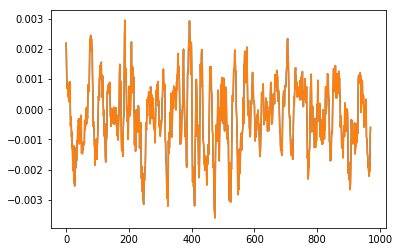

In [10]:
plt.figure(0)
plt.plot(features[:m_out,0])
plt.plot(returns[:,3])
print("Max diff ret var feat")
print(np.max(np.abs(features[:m_out,0])-np.abs(returns[:,3])))
print(np.argmax(np.abs(features[:m_out,0])-np.abs(returns[:,3])))

print("np.argmax(features[:m_out,0])")
print(np.argmax(features[:m_out,0]))
print(np.max(features[:m_out,0]))
print(np.argmax(returns[:,3]))
print(np.max(returns[:,3]))
print(np.argmin(features[:m_out,0]))
print(np.argmin(returns[:,3]))

In [5]:
f_raw.close()
file_features.close()
file_returns.close()
file_symbols.close()

In [8]:
import os
if os.path.exists(filename_features):
    os.remove(filename_features)
    print("Removed")
if os.path.exists(filename_returns):
    os.remove(filename_returns)
if os.path.exists(filename_symbols):
    os.remove(filename_symbols)

Removed


EURUSD
	 s 1 of 27. From 2016.04.25 03:00:00 to 2016.06.09 11:59:59
SymbolBid[2*nExS-1:].shape
(98001,)
SymbolBid[nExS-1:-(nExS)]
(98001,)
SymbolOut.shape
(98001,)
nE
99001
Features already exist
[[-1.10000000e-04 -1.88032339e-04  3.90519741e-05 ...  1.70377894e+01
   1.69789652e+01  1.69716726e+01]
 [ 1.20000000e-04 -3.96116195e-05  3.73048901e-05 ... -1.09595925e+00
  -1.16221300e+00 -1.17043960e+00]
 [-3.00000000e-05 -7.06129550e-06  3.39324634e-05 ...  1.83557953e+01
   1.82820074e+01  1.82728350e+01]
 ...
 [ 7.90000000e-04  4.07558291e-04 -1.18924465e-04 ...  4.22209170e+00
   2.27784367e+00  1.56290109e+00]
 [ 6.70000000e-04  6.25963808e-04  4.06508841e-05 ...  3.55964944e+00
   2.09640852e+00  1.39454649e+00]
 [ 7.60000000e-04  6.47960274e-04  1.52349246e-04 ...  3.39884027e+00
   2.20863942e+00  1.51764769e+00]]
(981, 25)
stats_feats
{'means': array([[ 3.53618756e-05,  3.36707180e-05,  3.38102732e-05,
         3.62258047e-05,  5.18411720e-05,  6.88262190e-05,
         1.8786254

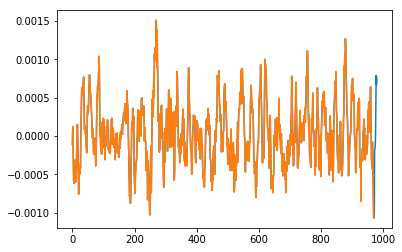

In [10]:
# Test get_features_from_var_raw
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import h5py
import time
from inputs import Data
from inputs import load_separators, Data
%matplotlib inline

hdf5_directory = 'D:/SDC/py/HDF5/'
fets_var_directory = hdf5_directory+'fets_var/'
filename_raw = hdf5_directory+'tradeinfo.hdf5'
filename_features = fets_var_directory+'test_ret_feat.hdf5'
filename_returns = fets_var_directory+'test_ret_ret.hdf5'
filename_symbols = fets_var_directory+'test_ret_symb2.hdf5'
file_features = h5py.File(filename_features,'a')
file_returns = h5py.File(filename_returns,'a')
file_symbols = h5py.File(filename_symbols,'a')
separators_directory = hdf5_directory+'separators/'
f_raw = h5py.File(filename_raw,'r')

data = Data(var_feat_keys=[i for i in range(68,93)],
            feature_keys_tsfresh=[])#[i for i in range(37,48)]+[49,50]+[i for i in range(52,68)]
nExS = data.nEventsPerStat
mW = data.movingWindow
nF = len(data.var_feat_keys)+data.n_feats_tsfresh

thisAsset = 'EURUSD'
print(thisAsset)
    
group_raw = f_raw[thisAsset]

# load separators
separators = load_separators(data, thisAsset, separators_directory, from_txt=1)
# loop over separators
s=2

nE = separators.index[s+1]-separators.index[s]+1
# check if number of events is not enough to build two features and one return
if nE>=2*data.nEventsPerStat:
    print("\t"+" s {0:d} of {1:d}".format(int(s/2),int(len(separators)/2-1))+
                      ". From "+separators.DateTime.iloc[s]+" to "+separators.DateTime.iloc[s+1])
    DateTime = group_raw["DateTime"][separators.index[s]:separators.index[s+1]+1]
    SymbolBid = group_raw["SymbolBid"][separators.index[s]:separators.index[s+1]+1]
    SymbolAsk = group_raw["SymbolAsk"][separators.index[s]:separators.index[s+1]+1]
    
    DateTime = DateTime[:100000]
    SymbolBid = SymbolBid[:100000]
    SymbolAsk = SymbolAsk[:100000]

    SymbolVar = SymbolBid[nExS-1:]-SymbolBid[:-(nExS-1)]
    print("SymbolBid[2*nExS-1:].shape")
    print(SymbolBid[2*nExS-1:].shape)
    print("SymbolBid[nExS-1:-(nExS)]")
    print(SymbolBid[nExS-1:-(nExS)].shape)
    SymbolOut = SymbolBid[2*nExS-1:]-SymbolBid[nExS-1:-(nExS)]
    print("SymbolOut.shape")
    print(SymbolOut.shape)
    nE = SymbolVar.shape[0]
    print("nE")
    print(nE)
    init_date, end_date = get_init_end_dates(separators, s)
    
    m_in, m_out = get_io_number_samples(nE, nExS, mW)     
    
    group_name = get_group_name(thisAsset, init_date, end_date)
    
    features, exist_feats = retrieve_manual_features_structure(file_features, group_name, m_in, nF)        
    
    if not exist_feats:
        features = get_features_from_var_raw(data, features, DateTime[nExS:], SymbolVar, nExS, mW, nE, m_in)
                
        stats_feats = calculate_stats_from_var_feats(features)
        
        save_stats_fn(file_features, group_name, stats_feats)
                
    else:
        print("Features already exist")
        stats_feats = retrieve_stats(file_features, group_name)
        
    print(features[:])
    all_feats = data.feature_keys_tsfresh+data.var_feat_keys
    #for i in range(features.shape[1]):
    #    plt.figure(i)
    #    plt.plot(features[:,i])
    #    plt.title(data.AllFeatures[str(all_feats[i])])
    print(features.shape)
    #stats_features = get_stats_from_var_feats(features)
    print("stats_feats")
    print(stats_feats)
    print(stats_feats['stds'].shape)
    
    returns, exist_rets = retrieve_returns_structure(file_returns, group_name, m_out, len(data.lookAheadVector))
    
    if not exist_rets:
        returns = get_returns(data, returns, SymbolBid, nE, nExS, mW, m_in)
        #print("returns")
        #print(returns)
        stats_rets = calculate_stats_from_returns(returns)
        #print("stats_rets")
        #print(stats_rets)
        save_stats_fn(file_returns, group_name, stats_rets)
    else:
        print("Returns already exist")
        stats_rets = retrieve_stats(file_returns, group_name)
        
    print("returns")
    print(returns[:])
    print(returns.shape)
    
    plt.figure(0)
    plt.plot(features[:,0])
    plt.plot(returns[:,3])
    print("Max diff ret var feat")
    print(np.max(np.abs(features[:m_out,0])-np.abs(returns[:,3])))
    #plt.title(data.AllFeatures[str(all_feats[i])])
    
    print("stats_rets")
    print(stats_rets)
    print(stats_rets['stds'].shape)
    
    DT, B, A, exist_symbs = retrieve_symbols_structure(file_symbols, group_name, m_out, len(data.lookAheadVector))
    
    if not exist_symbs:
        DT, B, A = get_symbols(data, DT, B, A, DateTime, SymbolBid, SymbolAsk, nE, nExS, mW, m_in)
        
    else:
        print("Symbols already exist")
    print("symbols")
    print(DT.shape)
    print(DT[:])
    print(B[:])
    print(A[:])
else:
    print("\ts {0:d} of {1:d}. Not enough entries. Skipped.".format(int(s/2),int(len(separators)/2-1)))
print("DONE")

#file_features.close()
#file_returns.close()
#file_symbols.close()
f_raw.close()

In [15]:
print(np.abs(features[:m_out,0]))
print(np.abs(returns[:,3]))
print(features[:m_out,0]-returns[:,3])

[2.19e-03 1.64e-03 9.70e-04 8.00e-04 6.70e-04 8.80e-04 4.30e-04 8.20e-04
 2.90e-04 2.60e-04 2.90e-04 7.40e-04 9.10e-04 2.80e-04 5.50e-04 2.60e-04
 2.60e-04 9.10e-04 7.50e-04 1.29e-03 1.18e-03 1.83e-03 2.04e-03 1.62e-03
 1.21e-03 2.43e-03 2.05e-03 2.54e-03 2.17e-03 1.93e-03 1.92e-03 1.94e-03
 1.27e-03 1.71e-03 1.53e-03 1.04e-03 1.17e-03 6.00e-04 1.07e-03 3.50e-04
 4.40e-04 3.10e-04 8.90e-04 1.14e-03 1.11e-03 1.02e-03 8.60e-04 4.40e-04
 2.00e-04 1.45e-03 1.38e-03 1.47e-03 1.47e-03 1.19e-03 1.36e-03 1.08e-03
 1.16e-03 1.18e-03 1.10e-03 3.70e-04 6.00e-04 6.70e-04 3.90e-04 5.10e-04
 3.00e-05 4.90e-04 7.00e-05 1.80e-04 3.00e-04 3.30e-04 8.10e-04 7.00e-04
 6.70e-04 5.90e-04 1.15e-03 1.95e-03 2.32e-03 2.19e-03 2.45e-03 1.92e-03
 2.35e-03 2.33e-03 2.01e-03 2.00e-03 1.09e-03 5.50e-04 5.60e-04 4.00e-04
 5.40e-04 6.20e-04 1.20e-03 1.25e-03 1.85e-03 1.30e-03 1.22e-03 1.28e-03
 9.90e-04 1.36e-03 1.66e-03 1.31e-03 9.90e-04 7.60e-04 1.80e-04 4.30e-04
 3.10e-04 6.20e-04 1.03e-03 1.11e-03 1.45e-03 1.34e

In [63]:
feature_keys_tsfresh

[37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 49,
 50,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67]